In [1]:
# Load helpers and custom dataset class
from __init__ import PricingWizardDataset, regression_accuracy, threshold_accuracy

# Data manipulation 
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Data preprocessing
from sklearn.preprocessing import StandardScaler, Normalizer, normalize


In [2]:
# Data loading
data = PricingWizardDataset(
    filename = 'post_preprocessing_without_dummies.csv'
)

Dataset Loaded: post_preprocessing_without_dummies
	Number of Rows: 283055
	Number of Columns: 22
	Outlier Removal: True
	Train Size: 0.8
	Test Size: 0.2
	Random State: 42


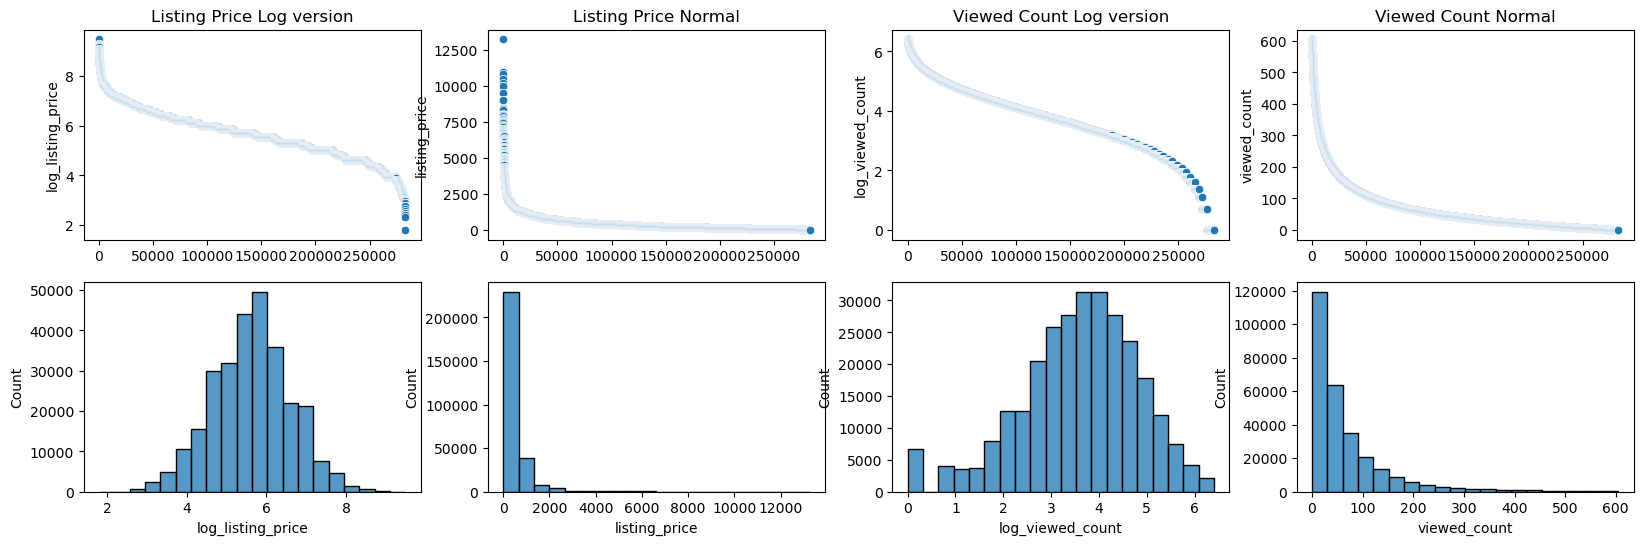

In [3]:
# Dependent variabel distribution + log versioned
fig, axs = plt.subplots(2, 4, figsize=(20, 6))
axs = axs.flatten()

# Listing price sorted
sns.scatterplot(x=list(range(len(data.df))), y=data.df.sort_values(by='listing_price', ascending=False).log_listing_price, ax=axs[0])
sns.scatterplot(x=list(range(len(data.df))), y=data.df.sort_values(by='listing_price', ascending=False).listing_price, ax=axs[1])
axs[0].set_title('Listing Price Log version')
axs[1].set_title('Listing Price Normal')

# Viewed count
sns.scatterplot(x=list(range(len(data.df))), y=data.df.sort_values(by='log_viewed_count', ascending=False).log_viewed_count, ax=axs[2])
sns.scatterplot(x=list(range(len(data.df))), y=data.df.sort_values(by='viewed_count', ascending=False).viewed_count, ax=axs[3])
axs[2].set_title('Viewed Count Log version')
axs[3].set_title('Viewed Count Normal')

# Listing price sorted
sns.histplot(x=data.df.log_listing_price, ax=axs[4], bins=20)
sns.histplot(x=data.df.listing_price, ax=axs[5], bins=20)

# Viewed count
sns.histplot(x=data.df.log_viewed_count, ax=axs[6], bins=20)
sns.histplot(x=data.df.viewed_count, ax=axs[7], bins=20)

plt.show()

# `Regression`

### Reminder of Some of the Basic Regression Assumptions
* Linearity: between the independent variables and the dependent variable
* Independece: Observations are assumed to be independent of each other
* Residuals: Normally distributed, and mean 0
* Multicollinearity: No or very limimted multicollinearity (correlation between independent variables)

The log transformed data will be used as that more closely mimics that of a normal distribution

```markdown 
Since ordinary least squares should enforce close to zero weights for irrelevant featues, we can include all, and see for which it excludes. However, given that some of these values are highly correlated (multicolineratity) some will be excluded in favor of others. These will likely be tested against each other later.

Excluding:
* classified price: My assumption is that this column is some type of classification performed by the company behind the data and is thus is already highly correlated.
* listed_at_date: This is likely not very relevant for pricing, and will be difficult to pass to a model without one-hot encoding the values, that will lead to too sparse vectors.
* user_id: irrelevant for classification. 
* View count is selected over favorites, as it has more variance - these quite correlated as seen below, which makes sense.
* Category_name, subcategory_name, subsubcategory_name: These are all an extension of each other, with each one becomming more and more granular. These are therefore dropped in favor of more granulaity.

```

In [4]:
# Compute pearson correlation coefficient
correlation = data.df['listing_price'].corr(data.df['classified_price'])
print('Listing -> Classified Price', correlation)


correlation = data.df['viewed_count'].corr(data.df['favourites'])
print('Viewed -> Favorites', correlation)


Listing -> Classified Price 0.9691267746228455
Viewed -> Favorites 0.8068321298641057


In [5]:
# Specify columns for model
columns_to_use = ['classified_id','log_viewed_count','log_listing_price', 'brand_name','condition_name','color_name','subsubsubcategory_name', 'listing_price']

# Drop unused columns
data.df = data.df[columns_to_use]

# Print head
data.df.head()

,classified_id,log_viewed_count,log_listing_price,brand_name,condition_name,color_name,subsubsubcategory_name,listing_price
0,30343099,4.983607,7.170120,Air Jordan,Almost as new,Black,Sneakers,1299
1,30346312,4.787492,5.860786,Ganni,Almost as new,Multi,Skirts,350
2,30364278,5.347108,4.795791,One Vintage,Good but used,Multi,Women,120
3,30406315,3.737670,6.111467,Ralph Lauren,"New, still with price",Navy,T-shirts,450
4,30420441,5.342334,6.398595,Air Jordan,Never used,Beige,Sneakers,600


In [6]:
# Apply one hot encoding to categorical variables
data.apply_function(pd.get_dummies, columns=data.df.columns[3:7])

data.df.head()

,classified_id,log_viewed_count,log_listing_price,listing_price,brand_name_& Other Stories,brand_name_(di)vision,brand_name_66 North,brand_name_7 DAYS ACTIVE,brand_name_A.P.C.,brand_name_AF Agger,...,subsubsubcategory_name_Wallets,subsubsubcategory_name_Wardrobes,subsubsubcategory_name_Watches,subsubsubcategory_name_Weekend bags,subsubsubcategory_name_Wireless speakers,subsubsubcategory_name_Women,subsubsubcategory_name_Yoga,subsubsubcategory_name_iPhone,subsubsubcategory_name_iPhones,subsubsubcategory_name_Øreringe
0,30343099,4.983607,7.170120,1299,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30346312,4.787492,5.860786,350,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30364278,5.347108,4.795791,120,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,30406315,3.737670,6.111467,450,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,30420441,5.342334,6.398595,600,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Base Model
Base model using regular regression (i.e. Ordinary Least Squares). As seen in earlier notebooks, we know the data is pretty skewed for its distribution. One consideration could be to transform our distribution using a log transformation

In [28]:
# Function to return data without clasiified_id
drop_helpers = lambda x: x.loc[:, (x.columns != 'classified_id') & (x.columns != 'listing_price')] 

In [8]:
# Base regrsesion model
base_model = LinearRegression()

# Train-test split
X_train, X_test, y_train, y_test = data.stratify_train_test_split(y_column='log_listing_price', val_size=0)

Dependent variable distribution is equal across all subsets


In [9]:
# Fitting model (without classified_id)
base_model.fit(drop_helpers(X_train), y_train)

LinearRegression()

In [10]:
# Accuracy of training set
prediction = base_model.predict(drop_helpers(X_train))
regression_accuracy(prediction, y_train)

# Reversing prediction to original scale
original_scale_predictions = np.exp(prediction)

R2 Score: 0.6360336964915287
MSE: 0.353142861721646
MAE 0.4564017409921661
RMSE 0.5942582449757394


```markdown
Pretty descent R2, and MSE given the complexity of the data
```

Residual Mean (Non-Original Scale) -0.00
Residual Mean (Orignal Scale) 69.20
4989.499795722117
10.425010383169749
13250
9


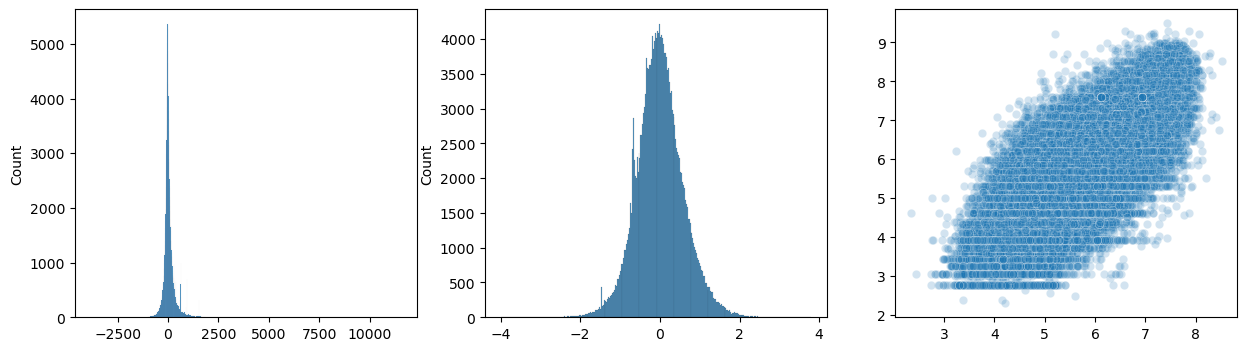

In [11]:
# Residual distribution and Prediction Plots
print(f'Residual Mean (Non-Original Scale) {np.mean(prediction - y_train):.2f}')
print(f'Residual Mean (Orignal Scale) {np.mean(X_train.listing_price.values - original_scale_predictions):.2f}')

# Create 3 column figure
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

sns.histplot(X_train.listing_price.values - original_scale_predictions, ax=axs[0])
sns.histplot(prediction - y_train, ax=axs[1])
sns.scatterplot(x=prediction, y=y_train, ax=axs[2], alpha=0.2)

# Exclude extreme outliers from histplot
# axs[0].set_xlim(-1000, 1000)


print(max(original_scale_predictions))
print(min(original_scale_predictions))
print(max(X_train.listing_price))
print(min(X_train.listing_price))


plt.show()

```markdown
We see the residauls quite closely followed that of a normal distribution with high intensity around 0. For the original scaled predictions, the residuals are similarly very close, with the average prediction being around 70kr's off. From the scatterplot between prediction and actual, their is a clear correlation trend.
```

In [12]:
# Accuracy of training set
original_scale_predictions = np.exp(prediction)

# Adding column to X_training copy
X_train_copy = X_train.copy()
X_train_copy['prediction'] = original_scale_predictions

# 
df0 = data.raw_df.copy()
df0 = df0.merge(X_train_copy[['classified_id','prediction']], on='classified_id')
df0['diff'] = round(df0.prediction - df0.listing_price, 3)

pd.options.display.float_format = '{:.5f}'.format


In [13]:
df0.sort_values(by='diff', ascending=False).head(10)

,classified_id,listed_at_date,user_id,classified_price,listing_price,favourites,viewed_count,brand_name,condition_name,color_name,...,classified_price_standardized,viewed_count_standardized,favourites_standardized,classified_price_normalized,viewed_count_normalized,favourites_normalized,log_listing_price,log_viewed_count,prediction,diff
78543,30979977,2023-10-08,1827015,800,850,20,483,Louis Vuitton,"New, still with price",Black,...,0.74060,3.92103,1.07798,0.10488,0.04447,0.06515,6.74641,6.18208,4702.31654,3852.31700
217463,30530190,2023-09-16,2250701,200,250,0,70,Balenciaga,"New, still with price",Black,...,-0.41854,-0.00672,-0.71178,0.02472,0.00644,0.00000,5.52545,4.26268,3677.79162,3427.79200
193133,30532872,2023-09-17,1233726,1200,1200,22,172,Balenciaga,"New, still with price",Brown,...,1.51335,0.96333,1.25695,0.15832,0.01584,0.07166,7.09091,5.15329,4457.97792,3257.97800
123103,30433333,2023-09-11,650699,270,400,12,251,Bottega Veneta,"New, still with price",Black,...,-0.28331,1.71465,0.36207,0.03407,0.02311,0.03909,5.99396,5.52943,3340.80774,2940.80800
25773,30627920,2023-09-21,2551179,1099,1099,8,127,Louis Vuitton,"New, still with price",NaN,...,1.31823,0.53537,0.00412,0.14482,0.01169,0.02606,7.00307,4.85203,4011.37863,2912.37900
188975,30595788,2023-09-19,1669152,380,500,2,34,Balenciaga,"New, still with price",Black,...,-0.07080,-0.34909,-0.53280,0.04876,0.00313,0.00651,6.21661,3.55535,3379.00205,2879.00200
46103,31593128,2023-11-07,2028389,2000,1300,4,161,Louis Vuitton,"New, still with price",Multi,...,3.05887,0.85872,-0.35383,0.26520,0.01482,0.01303,7.17089,5.08760,4101.93408,2801.93400
147548,30658591,2023-09-23,2448698,350,350,15,285,Mulberry,Good but used,Brown,...,-0.12876,2.03799,0.63054,0.04476,0.02624,0.04886,5.86079,5.65599,3105.10249,2755.10200
136453,30433355,2023-09-11,650699,275,400,4,70,Bottega Veneta,"New, still with price",Green,...,-0.27365,-0.00672,-0.35383,0.03474,0.00644,0.01303,5.99396,4.26268,3079.38741,2679.38700
70686,31538517,2023-11-05,2490723,750,600,20,318,Louis Vuitton,Almost as new,Blue,...,0.64400,2.35183,1.07798,0.09820,0.02928,0.06515,6.39859,5.76519,3215.32459,2615.32500


#### `Test Evaluation`
Evaluating base model on test set

In [14]:
# Perform prediction on test
prediction = base_model.predict(drop_helpers(X_test))
regression_accuracy(prediction, y_test)
print(f'Min: {min(prediction)}, Max: {max(prediction)}')
# There are clearly some extremes in the prediction

R2 Score: -7.019042982113432e+17
MSE: 6.762694909124806e+17
MAE 8588795.184006736
RMSE 822356060.9082179
Min: -135074638632.80548, Max: 15932943552.575546


```markdown
Moving into the test data, we see that the model has severely overfitted to the training data, and haven't been able to generalize onto the test set
```

In [15]:
# Accuracy of training set
original_scale_predictions = np.exp(prediction)

# Adding column to X_testing copy
X_test_copy = X_test.copy()
X_test_copy['prediction'] = original_scale_predictions

# 
df0 = data.raw_df.copy()
df0 = df0.merge(X_test_copy[['classified_id','prediction']], on='classified_id')
df0['diff'] = round(df0.prediction - df0.listing_price, 3)

/var/folders/v_/xl6xsh6x00990b93wzxm2j8c0000gn/T/ipykernel_16948/3629056761.py:2: RuntimeWarning: overflow encountered in exp
  original_scale_predictions = np.exp(prediction)


In [16]:
# Exclude extreme outliers and computing regression accuracy
df0.sort_values(by='diff', ascending=False).head(10)

,classified_id,listed_at_date,user_id,classified_price,listing_price,favourites,viewed_count,brand_name,condition_name,color_name,...,classified_price_standardized,viewed_count_standardized,favourites_standardized,classified_price_normalized,viewed_count_normalized,favourites_normalized,log_listing_price,log_viewed_count,prediction,diff
43707,30733163,2023-09-26,2408085,250,250,15,96,Unassigned_Shelving systems,"New, still with price",Black,...,-0.32195,0.24055,0.63054,0.03140,0.00884,0.04886,5.52545,4.57471,inf,inf
35383,31682069,2023-11-12,1000022,500,800,0,11,Unassigned_Shelving systems,Good but used,White,...,0.16103,-0.56782,-0.71178,0.06480,0.00101,0.00000,6.68586,2.48491,inf,inf
38294,31164662,2023-10-17,2345819,249,400,2,28,Unassigned_Falsh eyelashes,"New, still with price",NaN,...,-0.32388,-0.40615,-0.53280,0.03126,0.00258,0.00651,5.99396,3.36730,inf,inf
29816,30874682,2023-10-03,2295730,200,400,2,30,Unassigned_TV tables,Never used,Black,...,-0.41854,-0.38713,-0.53280,0.02472,0.00276,0.00651,5.99396,3.43399,inf,inf
30687,30343678,2023-09-06,1088422,300,600,16,175,Unassigned_TV tables,Almost as new,White,...,-0.22535,0.99186,0.72003,0.03808,0.01611,0.05212,6.39859,5.17048,inf,inf
51688,30690191,2023-09-24,2566870,160,160,4,125,Balenciaga,"New, still with price",Black,...,-0.49582,0.51635,-0.35383,0.01937,0.01151,0.01303,5.08140,4.83628,3560.01754,3400.01800
29631,31888104,2023-11-25,2603341,100,100,0,5,Unassigned_Tablets & Accessories,"New, still with price",NaN,...,-0.61173,-0.62488,-0.71178,0.01136,0.00046,0.00000,4.61512,1.79176,3324.28133,3224.28100
14354,31814454,2023-11-20,1934231,399,399,3,25,Louis Vuitton,"New, still with price",Navy,...,-0.03410,-0.43468,-0.44331,0.05130,0.00230,0.00977,5.99146,3.25810,3289.71600,2890.71600
24100,31001346,2023-10-09,1233223,100,100,4,18,Unassigned_Cots,Almost as new,NaN,...,-0.61173,-0.50125,-0.35383,0.01136,0.00166,0.01303,4.61512,2.94444,2865.79709,2765.79700
11406,31230161,2023-10-20,2070492,1100,1100,5,85,Louis Vuitton,"New, still with price",NaN,...,1.32016,0.13594,-0.26434,0.14496,0.00783,0.01629,7.00397,4.45435,3824.76505,2724.76500


In [17]:
# Exclude extreme outliers and computing regression accuracy
pred_ = df0[abs(df0['diff']) < 1000]['prediction'].values
listing_ = df0[abs(df0['diff']) < 1000]['listing_price'].values

regression_accuracy(pred_, listing_)

R2 Score: 0.6120965898042494
MSE: 53827.6876948966
MAE 150.91787553080107
RMSE 232.0079474821856


<Axes: xlabel='diff', ylabel='Count'>

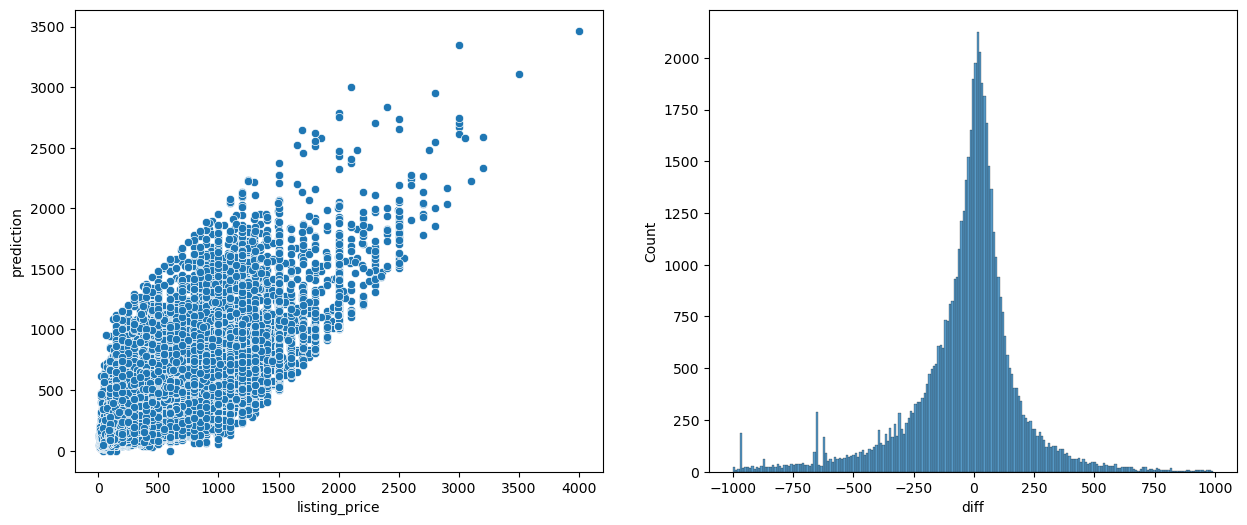

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Scatterplot of prediction vs listing price
sns.scatterplot(x=df0[abs(df0['diff']) < 1000].listing_price, y=df0[abs(df0['diff']) < 1000].prediction, ax=axs[0])

# Residual distribution
sns.histplot(df0[abs(df0['diff']) < 1000]['diff'], ax=axs[1])

# It's clear that the model is able to extract some information from the data, but it's still not very accurate considering above

```markdown
Interesting, when looking into the data we see the very wrong predictions are caused by a handful of predictions. It's likely that these vary too much in this data set as compared to the training set making it difficult for the model to infer anything for these listings. When excluding some of the extreme predictions, the correlation remains relatively similar as to the training data.
```

In [19]:
# Feature importance for base model

# Get the coefficients of the base model
coefficients = base_model.coef_

# Get the column names
column_names = drop_helpers(X_train).columns

# Create a dataframe to store the feature importance
feature_importance = pd.DataFrame({'Feature': column_names, 'Importance': coefficients})

feature_importance.sort_values(by='Importance', ascending=False).head(20)

,Feature,Importance
566,brand_name_Unassigned_Ladies bicycles,3599546182891.40967
943,subsubsubcategory_name_Electrical items,3387541409455.21973
967,subsubsubcategory_name_Games,3079590037124.17383
391,brand_name_Unassigned_Antiques,3073430989623.02930
885,subsubsubcategory_name_Brio,2811912642088.33936
654,brand_name_Unassigned_Racing bicycles,2485699726942.02588
1108,subsubsubcategory_name_Prams,2030983260225.61890
842,subsubsubcategory_name_Actionfigurer,2023459136751.04907
924,subsubsubcategory_name_DIY materials,2003934402317.86133
1010,subsubsubcategory_name_Kamera & video,1591331097339.26245


```markdown
Coefficients are completely off, and very extreme
```

#### Evaluating extereme predictions
```markdown
We'll be looking into coefficients for extereme predictions to see which are off
```

In [20]:
# Looking into most extreme predictions
X_test['scaled_listing_price'] = prediction
X_test['prediction'] = np.exp(prediction)
X_test['difference'] = X_test.prediction - X_test.listing_price

(X_test.sort_values(by='difference', ascending=False).iloc[0, 2:-3] * coefficients).sort_values(ascending=False).head(20)

/var/folders/v_/xl6xsh6x00990b93wzxm2j8c0000gn/T/ipykernel_16948/458089684.py:3: RuntimeWarning: overflow encountered in exp
  X_test['prediction'] = np.exp(prediction)


subsubsubcategory_name_TV tables   75658297271.16370
condition_name_Almost as new       40883397151.49139
brand_name_Unassigned_TV tables    13072239212.13425
listing_price                               71.87867
color_name_Grey                              0.00000
color_name_Multi                            -0.00000
color_name_Mint                             -0.00000
color_name_Metallic                          0.00000
color_name_Light grey                        0.00000
color_name_Light blue                       -0.00000
color_name_Green                             0.00000
color_name_Olive                             0.00000
color_name_Gold                              0.00000
color_name_Burgundy                         -0.00000
color_name_Brown                             0.00000
color_name_Blue                              0.00000
color_name_Black                            -0.00000
color_name_Beige                             0.00000
color_name_Navy                             -0

In [21]:
(X_test.sort_values(by='difference', ascending=False).iloc[1, 2:-3] * coefficients).sort_values(ascending=False).head(20)

subsubsubcategory_name_Shelving systems   75658297271.55376
condition_name_Good but used              40883397151.22963
brand_name_Unassigned_Shelving systems     5992143792.65113
listing_price                                      95.83823
subsubsubcategory_name_3/4 length                   0.00000
color_name_Green                                    0.00000
color_name_Multi                                   -0.00000
color_name_Mint                                    -0.00000
color_name_Metallic                                 0.00000
color_name_Light grey                               0.00000
color_name_Light blue                              -0.00000
color_name_Grey                                     0.00000
color_name_Gold                                     0.00000
color_name_Olive                                    0.00000
color_name_Burgundy                                -0.00000
color_name_Brown                                    0.00000
color_name_Blue                         

In [22]:
(X_train.iloc[:, 3:-3].sum(axis=0)- X_test.iloc[:, 3:-3].sum(axis=0)).sort_values(ascending=True).head(20)

brand_name_Unassigned_TV tables                -2.00000
brand_name_Unassigned_Shelving systems         -2.00000
brand_name_Unassigned_Yoga                     -1.00000
brand_name_Unassigned_Chandeliers              -1.00000
brand_name_Unassigned_Falsh eyelashes          -1.00000
subsubsubcategory_name_Tablets & Accessories   -1.00000
subsubsubcategory_name_Garbage cans            -1.00000
subsubsubcategory_name_Android                 -1.00000
brand_name_Unassigned_Android                  -1.00000
brand_name_Unassigned_Sports jackets           -1.00000
brand_name_Unassigned_Garbage cans             -1.00000
brand_name_Unassigned_Furniture                -1.00000
subsubsubcategory_name_Chandeliers             -1.00000
subsubsubcategory_name_Blu-Ray                  0.00000
subsubsubcategory_name_Mens bicycles            0.00000
subsubsubcategory_name_Car seats                0.00000
brand_name_Unassigned_Wall clocks               0.00000
subsubsubcategory_name_Cots                     

```markdown
Conclusion, we see that a some exterme coefficients are throwing the very wrong predictions completely off. The reason for this is that the values OHE appear very little across the dataset. It might be worth ensuring a mininmum threshold of X, or otherwise combine to a 'other' column, so this does not happen
```

### Base Model w/ Fewer Columns
```markdown
As seen above, unnassigned brand was a common denominator amongst the extereme predictions, which was causing some significant errors. Additionally, we'll use less granualar category columns. color_name will also be removes, as i suspect it does have much correlation with price. Lastly, a less granular category type will be used
```

##### Data Preperation for New Base Model

In [23]:
### Since only subsubsub category, color and viewed count can be seen among the top 10 features, we will try to remove the other features and see if the model improves

# Reset dataset
data.reset_dataset()

# New columns to use
columns_to_use = ['classified_id','log_viewed_count','log_listing_price','listing_price','brand_name','subsubcategory_name']

# Drop unused columns
data.df = data.df[columns_to_use]

# OHE. Will likely lead to too many columns
data.apply_function(pd.get_dummies, columns=['brand_name','subsubcategory_name'])

# Print head
data.df.head()


,classified_id,log_viewed_count,log_listing_price,listing_price,brand_name_& Other Stories,brand_name_(di)vision,brand_name_66 North,brand_name_7 DAYS ACTIVE,brand_name_A.P.C.,brand_name_AF Agger,...,subsubcategory_name_Skin care,subsubcategory_name_Smartphones & Accessories,subsubcategory_name_Sport,subsubcategory_name_Sports shoes,subsubcategory_name_Sportsudstyr,subsubcategory_name_Sportswear,subsubcategory_name_Til drenge,subsubcategory_name_Til piger,subsubcategory_name_Toys,subsubcategory_name_Women
0,30343099,4.98361,7.17012,1299,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30346312,4.78749,5.86079,350,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30364278,5.34711,4.79579,120,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,30406315,3.73767,6.11147,450,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,30420441,5.34233,6.39859,600,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# Evaluating frequency of subsubcategory_name
data.df[[col for col in data.df.columns if 'subsubcategory_name' in col]].sum(axis=0).sort_values(ascending=True).head(20)

subsubcategory_name_Sportsudstyr                     20
subsubcategory_name_Toys                             77
subsubcategory_name_Sports shoes                    208
subsubcategory_name_Furniture                       231
subsubcategory_name_Smartphones & Accessories       574
subsubcategory_name_Makeup                          840
subsubcategory_name_Sport                          1217
subsubcategory_name_Skin care                      1374
subsubcategory_name_Beauty & care                  1429
subsubcategory_name_Kids                           1636
subsubcategory_name_Electronics                    2168
subsubcategory_name_Til piger                      2546
subsubcategory_name_Fragrances                     2658
subsubcategory_name_Sportswear                     3132
subsubcategory_name_Til drenge                     3416
subsubcategory_name_Home                           7371
subsubcategory_name_Accessories                    9485
subsubcategory_name_Men                         

In [25]:
# Sportsudstyr subsubcategory has 20 listings, which is fine


# Using a less granular categroy type shows to not have as many low frequency listings
print(data.df[[col for col in data.df.columns if 'brand' in col]].sum(axis=0).sort_values(ascending=True).head(20))

# Evaluating number of brands with less than 50 listings
print('Columns with sum of only 1:', (data.df[[col for col in data.df.columns if 'brand' in col]].sum(axis=0).sort_values(ascending=True) < 50).sum())

brand_name_Unassigned_Double beds             1
brand_name_Unassigned_Falsh eyelashes         1
brand_name_Unassigned_Yoga                    1
brand_name_Unassigned_Ladies bicycles         1
brand_name_Unassigned_Eyeliner                1
brand_name_Unassigned_Benches                 1
brand_name_Unassigned_Office chairs           1
brand_name_Unassigned_VHS                     1
brand_name_Unassigned_Sofa beds               1
brand_name_Unassigned_Couches                 1
brand_name_Unassigned_Biking shoes            1
brand_name_Unassigned_Miscellaneous beds      1
brand_name_Unassigned_Chandeliers             1
brand_name_Unassigned_Android                 1
brand_name_Unassigned_Lounge chairs           1
brand_name_Unassigned_Sun care                1
brand_name_Unassigned_Fiskeri                 1
brand_name_Unassigned_Programs & softwares    1
brand_name_Unassigned_Body care               1
brand_name_Unassigned_Racing bicycles         1
dtype: int64
Columns with sum of only 1:

In [26]:
# Length of columns
print(f'Old length of columns: ', len(data.df.columns))

# Extracting infrequent brands
infrequent_brands = (data.df[[col for col in data.df.columns if 'brand' in col]].sum(axis=0).sort_values(ascending=True) < 50)
infrequent_brands = infrequent_brands[infrequent_brands == True].index

# Assigning 'other' to brands that are in infrequent_brands
data.df['brand_name_other'] = data.df[infrequent_brands].sum(axis=1)
data.df = data.df.drop(columns=infrequent_brands)

# Length of columns
print(f'New length of columns: ', len(data.df.columns))

Old length of columns:  826
New length of columns:  565


In [27]:
# Printing sum of columns to see if process was successful
data.df.iloc[:, 3:].sum(axis=0).sort_values(ascending=True).head(20)

subsubcategory_name_Sportsudstyr               20
brand_name_Unassigned_Nails & manicure         50
brand_name_Unassigned_Børnebøger               51
brand_name_Unassigned_Outdoor                  52
brand_name_Unassigned_Parfumer                 54
brand_name_Unassigned_Puzzles                  54
brand_name_Unassigned_Other for the kitchen    54
brand_name_Unassigned_Rain clothes             56
brand_name_Unassigned_Other beauty             56
brand_name_Unassigned_Collectors items         56
brand_name_Unassigned_Antiques                 57
brand_name_Unassigned_Galla & brudekjoler      58
brand_name_Unassigned_Other home textiles      58
brand_name_Unassigned_Nightwear                59
brand_name_Unassigned_Udklædning               59
brand_name_Unassigned_Haircare                 63
brand_name_Unassigned_Pantsuits                64
brand_name_Unassigned_Sport                    64
brand_name_Unassigned_Kids                     65
brand_name_Unassigned_Home accessories         65


#### Fitting Model

In [28]:
# Base regrsesion model
new_base_model = LinearRegression()

# Train-test split
X_train, X_test, y_train, y_test = data.stratify_train_test_split(y_column='log_listing_price', val_size=0)

Dependent variable distribution is equal across all subsets


In [29]:
# Fitting model (without classified_id)
new_base_model.fit(drop_helpers(X_train), y_train)

LinearRegression()

In [30]:
# Accuracy of training set
prediction = new_base_model.predict(drop_helpers(X_train))

regression_accuracy(prediction, y_train)
print(max(prediction))
print(min(prediction))


R2 Score: 0.4999252931471675
MSE: 0.4852037437265459
MAE 0.5424960153810051
RMSE 0.6965656779705313
7.712154388427734
2.7437477111816406


```Markdown
Slightly inferior results, however, this is not necessarily bad as better genearlization often cause model to fit worse
```

In [31]:
# Accuracy of test set
prediction = new_base_model.predict(drop_helpers(X_test))

regression_accuracy(prediction, y_test)
threshold_accuracy(prediction, y_test)

print('\n\nScaling back to original values')
regression_accuracy(np.exp(prediction), X_test.listing_price)
print(min(np.exp(prediction)))
print(max(np.exp(prediction)))


R2 Score: 0.497654882131105
MSE: 0.48399857073004837
MAE 0.5415483145910576
RMSE 0.6957000580207309
Threshold Accuracy 0.34064051156135733


Scaling back to original values
R2 Score: -1.045329007110762
MSE: 608258.3469499194
MAE 575.5031559935735
RMSE 779.909191476751
22.142353401989315
2194.7362057445303


```markdown
Test prediction is a lot better and more similar to the that of training, which proves our efforts worked. We do however not achieve a generally very good accuracy. Will look into coefficients again for test predictions that went wrong
```

In [32]:
# Feature importance for base model
# Get the coefficients of the base model
coefficients = new_base_model.coef_

# Get the column names
column_names = drop_helpers(X_train).columns

# Create a dataframe to store the feature importance
feature_importance = pd.DataFrame({'Feature': column_names, 'Importance': coefficients})

feature_importance.sort_values(by='Importance', ascending=False).head(20)

,Feature,Importance
546,subsubcategory_name_Furniture,20472802411.04790
552,subsubcategory_name_Smartphones & Accessories,20472802410.83451
555,subsubcategory_name_Sportsudstyr,20472802410.80817
544,subsubcategory_name_Electronics,20472802410.60376
554,subsubcategory_name_Sports shoes,20472802410.35788
560,subsubcategory_name_Women,20472802410.35371
550,subsubcategory_name_Men,20472802410.35241
553,subsubcategory_name_Sport,20472802410.28043
543,subsubcategory_name_Clothes,20472802410.20324
547,subsubcategory_name_Home,20472802409.97628


```markdown
Again, we see extreme coefficients, this time most of which are related to subsub categories. Interestingly we see sportsudsyr in their again, which is one of the less frequent ones in the dataset
```

In [33]:
# Looking into most extreme predictions
X_test['scaled_listing_price'] = prediction
X_test['prediction'] = np.exp(prediction)
X_test['difference'] = X_test.prediction - X_test.listing_price

(X_test.sort_values(by='difference', ascending=False).iloc[0, 2:-3] * coefficients).sort_values(ascending=False)

subsubcategory_name_Men         20472802410.35241
brand_name_Canada Goose          2813683894.10977
listing_price                            33.25510
brand_name_Totême                         0.00000
brand_name_Tekla                          0.00000
                                       ...       
brand_name_Joha                           0.00000
brand_name_Jean Paul Gaultier             0.00000
brand_name_Jane Kønig                     0.00000
brand_name_Jaded London                   0.00000
brand_name_other                          0.00000
Name: 152152, Length: 562, dtype: float64

In [34]:
# New extreme prediction
(X_test.sort_values(by='difference', ascending=False).iloc[3, 2:-3] * coefficients).sort_values(ascending=False)

subsubcategory_name_Women       20472802410.35371
brand_name_UGG                   2813683894.00201
listing_price                            66.51021
brand_name_Totême                         0.00000
brand_name_Tekla                          0.00000
                                       ...       
brand_name_Jean Paul Gaultier             0.00000
brand_name_Jane Kønig                     0.00000
brand_name_Jaded London                   0.00000
brand_name_Jacqueline De Yong             0.00000
brand_name_other                          0.00000
Name: 81455, Length: 562, dtype: float64

We're seeing very exterme predictions for certain brands. Lets try and encode these differently

### Alternative Encoding Methods

Given the extereme coefficients in earlier attempts, this time we'll try a different encoding method than OHE. More details and reasoning are provided below

* Condition Name: This categorical column already follows a natural progressing scale, i.e.: Shabby -> Good, but used -> Almost as new -> Never Used -> New, still with price. Therefore, rather than one-hot encode these, we will try and ordinal encoding based on the order provided 


In [17]:
data.reset_dataset()

# Ordinal Encoding for condition, since this typically follows some sort of order
condition_name = ['Shabby', 'Good but used','Almost as new', 'Never used', 'New, still with price']

# Encoding brands so most popular brands have the highest and vice versa. This is not the most appropriate method, as some brands are likely equal in price, and a better representation, taking in context could be used
brand_encoding = data.df.groupby('brand_name').agg({'log_listing_price': 'mean'}).sort_values(by='log_listing_price', ascending=True).to_dict()['log_listing_price']

# Dataframe
data.raw_df.iloc[:, :14].head()

,classified_id,listed_at_date,user_id,classified_price,listing_price,favourites,viewed_count,brand_name,condition_name,color_name,category_name,subcategory_name,subsubcategory_name,subsubsubcategory_name
0,30343099,2023-09-06,2425635,900,1299,10,145,Air Jordan,Almost as new,Black,Men,Men,Men,Sneakers
1,30346312,2023-09-06,144602,225,350,12,119,Ganni,Almost as new,Multi,Women,Women,Clothes,Skirts
2,30364278,2023-09-07,2028837,120,120,38,209,One Vintage,Good but used,Multi,Women,Women,Women,Women
3,30406315,2023-09-10,1953400,450,450,5,41,Ralph Lauren,"New, still with price",Navy,Men,Men,Clothes,T-shirts
4,30420441,2023-09-11,2202926,500,600,14,208,Air Jordan,Never used,Beige,Men,Men,Men,Sneakers


In [18]:
# Applying encoding (+1 to avoid 0)
data.df['brand_name'] = data.df['brand_name'].apply(lambda x: brand_encoding[x] + 1)
data.df['condition_name'] = data.df['condition_name'].apply(lambda x: condition_name.index(x) +1)


In [19]:
# Mapping rare subsubsubsub categories to 'Other' (those with less than 30 listings or around 0.01%
minimum = 30
print(f'Number of subsubsub categories with less than {minimum} listings:', sum(data.df.subsubsubcategory_name.value_counts() < minimum), ' or ', round(sum(data.df.subsubsubcategory_name.value_counts() < minimum) / len(data.df) * 100, 2), '% of dataset')

rare_sub_categories = pd.DataFrame(data.df.subsubsubcategory_name.value_counts()).where(data.df.subsubsubcategory_name.value_counts() < minimum).dropna().index

Number of subsubsub categories with less than 30 listings: 146  or  0.05 % of dataset


In [20]:
# Replacing with subcategory name
data.df[data.df.subsubsubcategory_name.isin(rare_sub_categories)].subcategory_name.value_counts()

Home             681
Beauty & care    213
Kids             182
Electronics      168
Women            108
Sport            107
Men               57
Name: subcategory_name, dtype: int64

In [21]:
# Applying transformation
data.df.loc[data.df[data.df.subsubsubcategory_name.isin(rare_sub_categories)].index, 'subsubsubcategory_name'] = data.df[data.df.subsubsubcategory_name.isin(rare_sub_categories)].subcategory_name

In [22]:
# Ordinal encoding for subsubsubcategory_name
subsubsubcategory_encoding = data.df.groupby('subsubsubcategory_name').agg({'log_listing_price': 'mean'}).sort_values(by='log_listing_price', ascending=True).to_dict()['log_listing_price']

# Applying encoding
data.df['subsubsubcategory_name'] = data.df['subsubsubcategory_name'].apply(lambda x: subsubsubcategory_encoding[x])

data.df.head()

,classified_id,listed_at_date,user_id,classified_price,listing_price,favourites,viewed_count,brand_name,condition_name,color_name,...,subsubcategory_name,subsubsubcategory_name,classified_price_standardized,viewed_count_standardized,favourites_standardized,classified_price_normalized,viewed_count_normalized,favourites_normalized,log_listing_price,log_viewed_count
0,30343099,2023-09-06,2425635,900,1299,10,145,7.880371,3,Black,...,Men,6.421452,0.933785,0.706555,0.183100,0.118236,0.013349,0.032573,7.170120,4.983607
1,30346312,2023-09-06,144602,225,350,12,119,7.108272,3,Multi,...,Clothes,5.040240,-0.370245,0.459288,0.362075,0.028056,0.010956,0.039088,5.860786,4.787492
2,30364278,2023-09-07,2028837,120,120,38,209,6.161306,2,Multi,...,Women,5.582274,-0.573094,1.315213,2.688753,0.014028,0.019241,0.123779,4.795791,5.347108
3,30406315,2023-09-10,1953400,450,450,5,41,6.705055,5,Navy,...,Clothes,5.423886,0.064432,-0.282514,-0.264338,0.058116,0.003775,0.016287,6.111467,3.737670
4,30420441,2023-09-11,2202926,500,600,14,208,7.880371,4,Beige,...,Men,6.421452,0.161027,1.305703,0.541050,0.064796,0.019149,0.045603,6.398595,5.342334


In [23]:
### Columns used for regression
columns_to_use = ['classified_id','log_listing_price','brand_name','condition_name','subsubsubcategory_name']

# Drop unused columns
data.df = data.df[columns_to_use]

# # OHE. Will likely lead to too many columns
# data.apply_function(pd.get_dummies, columns = ['subsubsubcategory_name'])

# Print head
data.df.head()


,classified_id,log_listing_price,brand_name,condition_name,subsubsubcategory_name
0,30343099,7.170120,7.880371,3,6.421452
1,30346312,5.860786,7.108272,3,5.040240
2,30364278,4.795791,6.161306,2,5.582274
3,30406315,6.111467,6.705055,5,5.423886
4,30420441,6.398595,7.880371,4,6.421452


In [24]:
# Ensuring no too unique columns
data.df.iloc[:, 2:].sum(axis=0).sort_values(ascending=True).head(20)

condition_name            8.999490e+05
subsubsubcategory_name    1.592611e+06
brand_name                1.875666e+06
dtype: float64

In [25]:
# Ensuring no too unique columns
data.df.iloc[:, 2:].sum(axis=0).sort_values(ascending=True).head(20)

condition_name            8.999490e+05
subsubsubcategory_name    1.592611e+06
brand_name                1.875666e+06
dtype: float64

In [26]:
# Base regrsesion model
new_base_model = LinearRegression()

# Train-test split
X_train, X_test, y_train, y_test = data.stratify_train_test_split(y_column='log_listing_price', val_size=0)

Dependent variable distribution is equal across all subsets


In [30]:
# Fitting model (without classified_id)
new_base_model.fit(drop_helpers(X_train), y_train)

# Accuracy of training set
prediction = new_base_model.predict(drop_helpers(X_train))

print('Accuracy Metrics (Log Scaled)')
regression_accuracy(prediction, y_train)
# Ressidual
print(f'Average Residuals: {np.mean(prediction - y_train):.2f}')
print(f'STD Residuals: {np.std(prediction - y_train):.2f}')

# Accuracy on regular scale
print('\nAccuracy Metrics (Regular Scale)')
regression_accuracy(np.exp(prediction), np.exp(y_train))
print('Max prediction', max(np.exp(prediction)))
print('Min prediction', min(np.exp(y_train)))
# Ressidual
print(f'Average Residuals: {np.mean(np.exp(prediction) - np.exp(y_train)):.2f}')
print(f'STD Residuals: {np.std(np.exp(prediction) - np.exp(y_train)):.2f}')


Accuracy Metrics (Log Scaled)
R2 Score: 0.5452003080918668
MSE: 0.44127509377203356
MAE 0.5159723483016466
RMSE 0.6642854008421633
Average Residuals: 0.00
STD Residuals: 0.66

Accuracy Metrics (Regular Scale)
R2 Score: 0.35385496852795717
MSE: 190892.29358137777
MAE 213.0350925589521
RMSE 436.9122264040888
Max prediction 3013.2497191410293
Min prediction 10.000000000000002
Average Residuals: -85.56
STD Residuals: 428.45


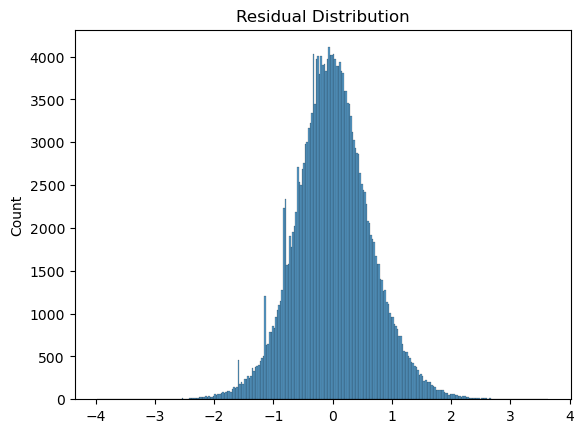

In [47]:
sns.histplot(prediction - y_train)
plt.title('Residual Distribution')
plt.show()

#### Accuracy on Test

R2 Score: 0.5452212770709474
MSE: 0.4381693860784058
MAE 0.5134875030165035
RMSE 0.6619436426754213
8.01077441626046
2.9584878746592276
-0.0006116797962555865
0.6619433600590254


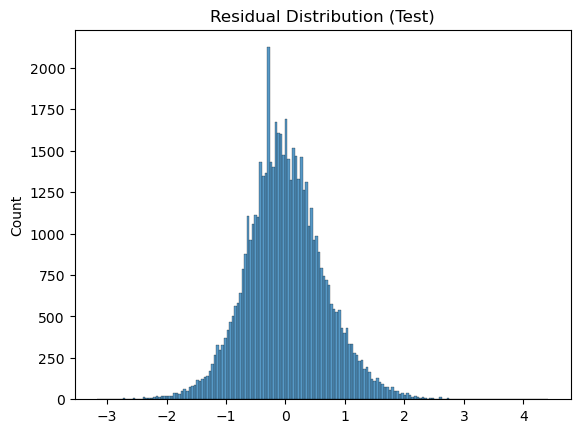

In [31]:
# Accuracy of training set
prediction = new_base_model.predict(drop_helpers(X_test))

regression_accuracy(prediction, y_test)
print(max(prediction))
print(min(prediction))


# Ressidual
print(np.mean(prediction - y_test))
print(np.std(prediction - y_test))

# Residual Distribution
plt.title('Residual Distribution (Test)')
sns.histplot(prediction - y_test)
plt.show()

### Better than before, but still not great

In [32]:
# Feature importance for base model
# Get the coefficients of the base model
coefficients = new_base_model.coef_

# Get the column names
column_names = drop_helpers(X_train).columns

# Create a dataframe to store the feature importance
feature_importance = pd.DataFrame({'Feature': column_names, 'Importance': coefficients})

feature_importance.sort_values(by='Importance', ascending=False).head(20)

,Feature,Importance
0,brand_name,0.823904
2,subsubsubcategory_name,0.499274
1,condition_name,0.152920


```markdown
This time, it seems coefficients are behaving much more normal, and it seems it's accurately learned to use the brand_name embedding. This is arguably the most reasoanble model, and so far the best performing one.
```


#### Evaluating wrong predictions
```markdown
We see from the residuals how some of predictions are quite alot off. We'll look into what might cause this below

```

In [33]:
# Adding prediction to X_test
X_test['log_listing_price'] = y_test
X_test['log_prediction'] = prediction
X_test['regular_scaled_prediction'] = np.exp(prediction)

In [36]:
# Compute difference between prediction and listing price
X_test['difference_normal_scale'] = abs(X_test['regular_scaled_prediction'] - np.exp(y_test))

In [38]:
# Predictions for regular data
X_test_prediction = data.raw_df.iloc[:, :14].merge(X_test[['classified_id','regular_scaled_prediction', 'difference_normal_scale']], on='classified_id', how='inner')


# Determines percentage the prediction is off
X_test_prediction['percent_off'] = X_test_prediction.regular_scaled_prediction / X_test_prediction.listing_price

X_test_prediction.head()

,classified_id,listed_at_date,user_id,classified_price,listing_price,favourites,viewed_count,brand_name,condition_name,color_name,category_name,subcategory_name,subsubcategory_name,subsubsubcategory_name,regular_scaled_prediction,difference_normal_scale,percent_off
0,30343099,2023-09-06,2425635,900,1299,10,145,Air Jordan,Almost as new,Black,Men,Men,Men,Sneakers,1128.796822,171.203178,0.868974
1,30511575,2023-09-16,1125898,200,200,18,66,One Vintage,Good but used,Army green,Women,Women,Clothes,Tops,106.206040,94.793960,0.531030
2,30346963,2023-09-06,1349247,300,300,4,27,Molo,Almost as new,Multi,Kids,Kids,Til piger,Snow suits,112.601021,188.398979,0.375337
3,30373005,2023-09-08,2160468,850,2000,12,94,BLS Hafnia,Almost as new,Blue,Men,Men,Men,Tops,217.952482,1783.047518,0.108976
4,30442305,2023-09-12,922672,150,200,25,220,One Vintage,Almost as new,NaN,Women,Women,Women,Shoulder bags,219.911948,18.911948,1.099560


In [39]:
# X test prediction sorted by percentage off
X_test_prediction.sort_values(by='percent_off', ascending=False).head(15).iloc[:, 4:]


,listing_price,favourites,viewed_count,brand_name,condition_name,color_name,category_name,subcategory_name,subsubcategory_name,subsubsubcategory_name,regular_scaled_prediction,difference_normal_scale,percent_off
48615,20,1,1,Unassigned_Computere,"New, still with price",Grey,Electronics,Electronics,Electronics,Computere,1739.379090,1718.379090,86.968954
45118,20,0,0,Unassigned_Electronics,"New, still with price",Black,Electronics,Electronics,Electronics,Electronics,670.214395,649.214395,33.510720
15687,20,4,62,Adidas,Good but used,White,Men,Men,Men,Shoes,592.634250,571.634250,29.631712
21750,50,8,219,Louis Vuitton,Never used,Orange,Women,Women,Women,Crossbody bags,1206.774805,1155.774805,24.135496
25752,25,2,52,Chanel,"New, still with price",Multi,Men,Beauty & care,Fragrances,Eau de Toilette,590.521502,564.521502,23.620860
17002,30,3,16,66 North,Almost as new,Black,Women,Women,Women,Belts,707.301546,676.301546,23.576718
32848,20,0,3,Nike,Almost as new,NaN,Men,Men,Men,Sneakers,460.243979,439.243979,23.012199
42042,10,3,12,Unassigned_Crossbody bags,Good but used,NaN,Women,Women,Women,Crossbody bags,189.163078,178.163078,18.916308
20735,50,1,1,Prada,"New, still with price",Multi,Men,Beauty & care,Fragrances,Eau de Toilette,912.780475,861.780475,18.255610
54551,25,1,18,Hermès,Almost as new,Multi,Men,Men,Men,Ties,442.960519,416.960519,17.718421


```Markdown
Looking into prediction where the percentage is off by a lot, we can also see how these listings have very low prices, compared to their category. E.g., the prediction with the higest actual difference is a new, still with price computer, that was predicted at around 1000k. A reasonable prediction taken everything into consideration, however, the actual listing price was 20kr, which is an unlikely case. Moreovr, we see a Louis Vuitton Crossbody Bag for 20kr, where our model predicts around 1.5k - another reasonable prediction, but where the listing price is completely off
```

```Markdown
Taking everything into consideration, it seems that last model is the most supperior performing one, with reasoanble coefficients. Therefore, this model will serve as our baseline model. 
```